# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
# !pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-07-24,70100,70900,69900,70400,13418597,0.001422
2023-07-25,70000,70500,69800,70000,14314945,-0.005682
2023-07-26,69800,70600,68100,69800,30016221,-0.002857
2023-07-27,69900,71700,69300,71700,24261179,0.027221
2023-07-28,71800,72400,70100,70600,19004018,-0.015342


**미국 주식 데이터**도 가져올 수 있습니다.

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-24,193.410004,194.910004,192.250000,192.750000,192.750000,45377800
2023-07-25,193.330002,194.440002,192.919998,193.619995,193.619995,37283200
2023-07-26,193.669998,195.639999,193.320007,194.500000,194.500000,47471900
2023-07-27,196.020004,197.199997,192.550003,193.220001,193.220001,47460200
2023-07-28,194.669998,196.630005,194.139999,195.830002,195.830002,48254600


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.095848,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.065521,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.203163,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.506428,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.758368,134247600


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [11]:
ford.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,1.297609,1.328022,1.287471,1.287471,0.243910,2044376
1980-01-03,1.287471,1.287471,1.267196,1.287471,0.243910,2816257
1980-01-04,1.287471,1.287471,1.272265,1.277334,0.241990,3038203
1980-01-07,1.277334,1.287471,1.267196,1.267196,0.240069,2251526
1980-01-08,1.267196,1.292540,1.257059,1.292540,0.244871,4069022


In [12]:
ford.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-20,9.50,9.54,9.44,9.48,8.255194,50191200
2019-12-23,9.50,9.57,9.40,9.44,8.220361,54784400
2019-12-24,9.44,9.49,9.43,9.47,8.246487,11881600
2019-12-26,9.47,9.49,9.43,9.45,8.229070,28961300
2019-12-27,9.45,9.46,9.35,9.36,8.150698,28272800


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [13]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니,

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [14]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [15]:
stock = fdr.DataReader(STOCK_CODE)

In [16]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-04-19,2064,2181,2015,2172,1238429,NaN
1999-04-20,2172,2230,2054,2094,735432,-0.035912
1999-04-21,2054,2083,1947,1947,662461,-0.070201
1999-04-22,1956,1976,1905,1953,928226,0.003082
1999-04-23,1952,2093,1941,1996,588279,0.022017


In [17]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-07-24,70100,70900,69900,70400,13418597,0.001422
2023-07-25,70000,70500,69800,70000,14314945,-0.005682
2023-07-26,69800,70600,68100,69800,30016221,-0.002857
2023-07-27,69900,71700,69300,71700,24261179,0.027221
2023-07-28,71800,72400,70100,70600,19004018,-0.015342


In [18]:
stock.index

DatetimeIndex(['1999-04-19', '1999-04-20', '1999-04-21', '1999-04-22',
               '1999-04-23', '1999-04-26', '1999-04-27', '1999-04-28',
               '1999-04-29', '1999-04-30',
               ...
               '2023-07-17', '2023-07-18', '2023-07-19', '2023-07-20',
               '2023-07-21', '2023-07-24', '2023-07-25', '2023-07-26',
               '2023-07-27', '2023-07-28'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [19]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [20]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1999-04-19,2064,2181,2015,2172,1238429,NaN,1999,4,19
1999-04-20,2172,2230,2054,2094,735432,-0.035912,1999,4,20
1999-04-21,2054,2083,1947,1947,662461,-0.070201,1999,4,21
1999-04-22,1956,1976,1905,1953,928226,0.003082,1999,4,22
1999-04-23,1952,2093,1941,1996,588279,0.022017,1999,4,23


## 시각화

Text(0, 0.5, 'price')

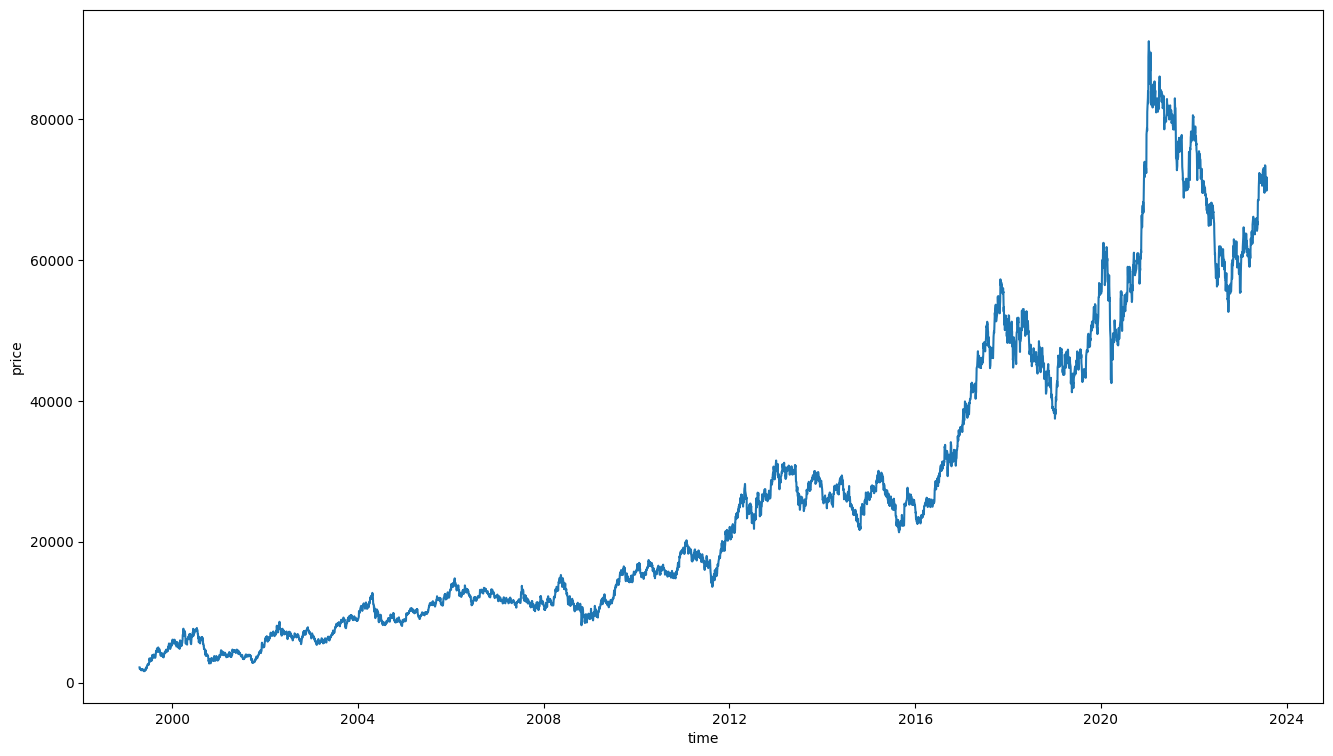

In [21]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

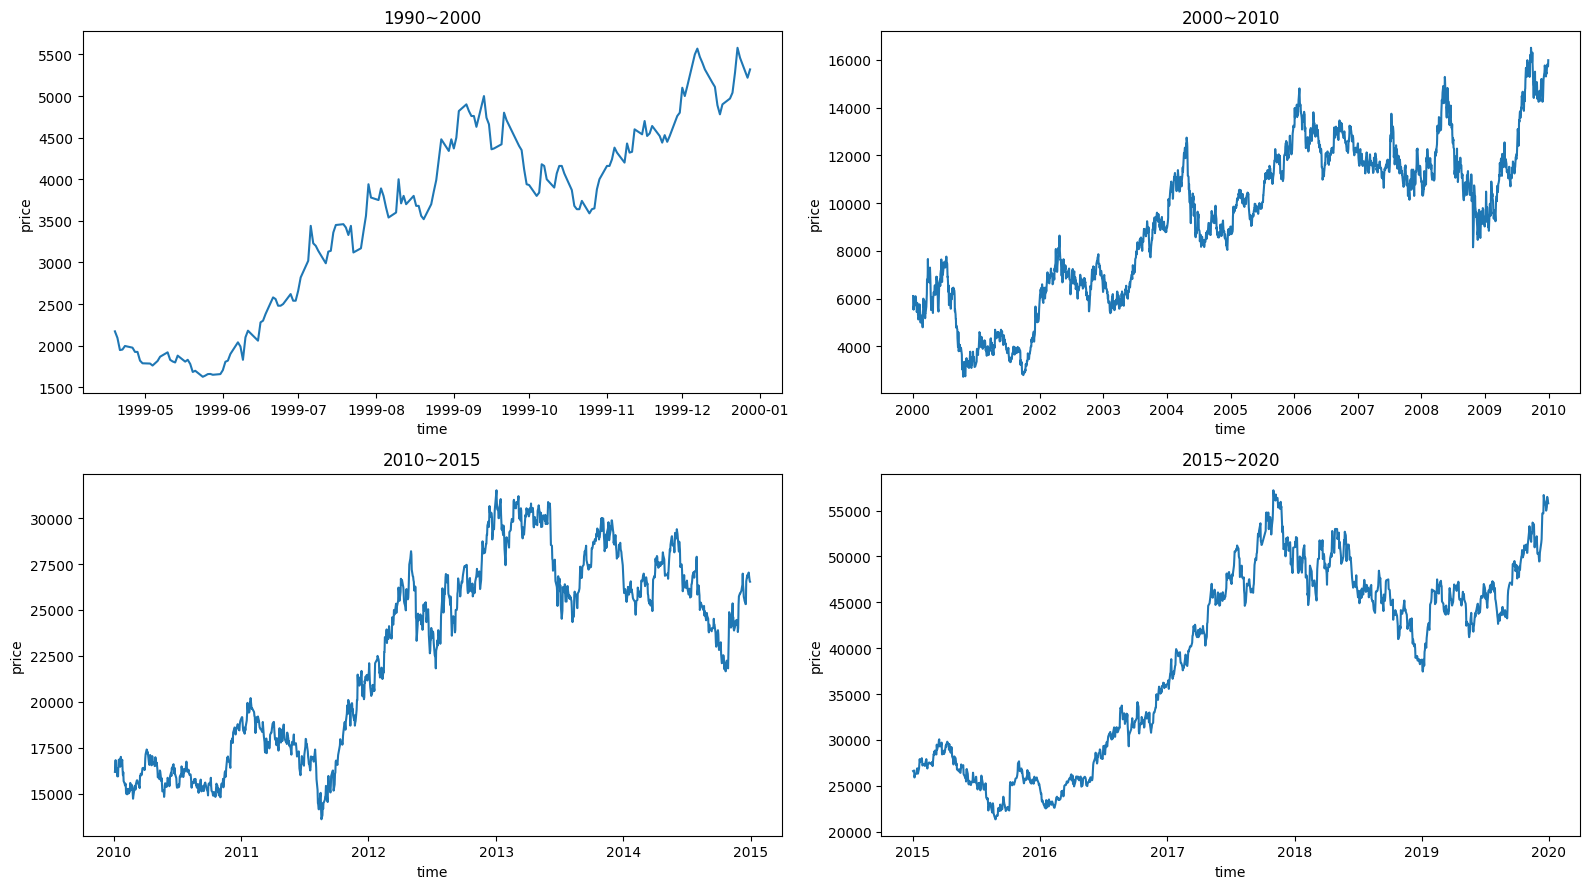

In [22]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.02285714, 0.02253099, 0.02251397, 0.00610916, 0.01371367],
       [0.02405316, 0.02303719, 0.02294972, 0.00523642, 0.00814376],
       [0.0227464 , 0.0215186 , 0.02175419, 0.00359165, 0.00733572],
       ...,
       [0.77297896, 0.72933884, 0.76089385, 0.76279455, 0.33238281],
       [0.77408638, 0.74070248, 0.77430168, 0.78405353, 0.2686547 ],
       [0.79512735, 0.74793388, 0.78324022, 0.7717457 , 0.21043985]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [24]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [27]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [28]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [29]:
x_train

,Open,High,Low,Volume
0,0.022857,0.022531,0.022514,0.013714
1,0.024053,0.023037,0.022950,0.008144
2,0.022746,0.021519,0.021754,0.007336
3,0.021661,0.020413,0.021285,0.010279
4,0.021617,0.021622,0.021687,0.006514
...,...,...,...,...
4795,0.503322,0.470558,0.502793,0.110511
4796,0.504430,0.474174,0.503352,0.109248
4797,0.497231,0.465909,0.497207,0.143902
4798,0.493355,0.462293,0.491620,0.202400


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [30]:
import tensorflow as tf

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [32]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [33]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [34]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [36]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [37]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [38]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 14s 9ms/step - loss: 1.1611e-04 - mse: 2.3221e-04
Epoch 1: val_loss improved from inf to 0.00086, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 16s 21ms/step - loss: 1.1611e-04 - mse: 2.3221e-04 - val_loss: 8.5725e-04 - val_mse: 0.0017
Epoch 2/50
149/150 [============================>.] - ETA: 0s - loss: 4.8554e-05 - mse: 9.7108e-05
Epoch 2: val_loss improved from 0.00086 to 0.00056, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 3s 17ms/step - loss: 4.8697e-05 - mse: 9.7394e-05 - val_loss: 5.6004e-04 - val_mse: 0.0011
Epoch 3/50
149/150 [============================>.] - ETA: 0s - loss: 4.1696e-05 - mse: 8.3393e-05
Epoch 3: val_loss did not improve from 0.00056
150/150 [==============================] - 3s 20ms/step - loss: 4.1752e-05 - mse: 8.3505e-05 - val_loss: 6.1807e-04 - val_mse: 0.0012
Epoch 4/50
149/150 [============================>.] - ETA: 0s - loss: 4.1621e-05 - mse: 8.3242e-0

저장한 ModelCheckpoint 를 로드합니다.

In [39]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [40]:
pred = model.predict(test_data)

37/37 [==============================] - 1s 9ms/step


In [41]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

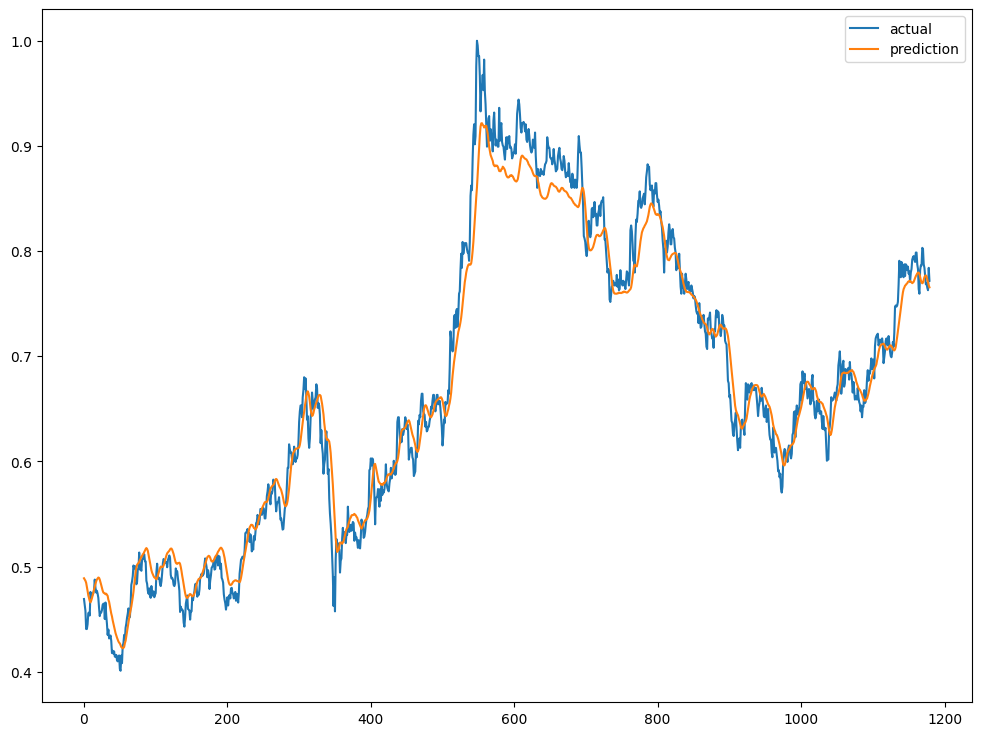

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()